# Deep Learning - Workshop

In [3]:
import glob
import pickle
import numpy as np
from prettytable import PrettyTable
from matplotlib import pyplot as plt
import pandas as pd

# Packages for autoencoder:
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.optimizers import SGD

# Packages for Black-Body function:
from astropy.modeling.models import BlackBody
from astropy import units as u
from astropy.visualization import quantity_support

In [4]:
path_spectra = "/data/schools/Astrostatistics_School_Crete_2022/2022_summer_school/Deep Learning/make_spectra/spectra_noabs"

n_spectra = 10000
# number of spectra to use

In [5]:
%%time
spectrum_files = glob.glob(path_spectra+'/*.pkl')

# Capping number of spectra:
spectrum_files = spectrum_files[:n_spectra]

# Creating data structure:
X = []
Y = []

for spectrum_file in spectrum_files:
    with open(spectrum_file, 'rb') as fh:
        spectrum = pickle.load(fh)

    spectrum_data     = spectrum['data']
    spectrum_metadata = spectrum['metadata']

    X.append(spectrum_data['flux_Jy'])
    Y.append(spectrum_metadata)

wave_mu = spectrum_data['wave_mu']
# the same for all spectra (using here the last spectrum)
    
X = np.array(X)

CPU times: user 312 ms, sys: 75.9 ms, total: 387 ms
Wall time: 388 ms


## Preparing Data

In [6]:
# Splitting dataset into train/validation/test sets:
X_rest, X_test, Y_rest, Y_test = train_test_split(X, Y, test_size=0.1, random_state=1)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_rest, Y_rest, test_size=0.3, random_state=1)

del X_rest
# purging exploited variable to save memory

table = PrettyTable()
table.title = 'Train/valid/test data shape'
table.field_names = ['', 'X', 'y']
table.add_row(['train', np.shape(X_train), np.shape(Y_train)])
table.add_row(['valid', np.shape(X_valid), np.shape(Y_valid)])
table.add_row(['test', np.shape(X_test), np.shape(Y_test)])
print(table)

+-------------------------------+
|  Train/valid/test data shape  |
+-------+-------------+---------+
|       |      X      |    y    |
+-------+-------------+---------+
| train | (6300, 100) | (6300,) |
| valid | (2700, 100) | (2700,) |
|  test | (1000, 100) | (1000,) |
+-------+-------------+---------+


### Normalizing data

In [7]:
# Normalizing data:
norm = MinMaxScaler()
norm.fit(X_train)
'''
X_n_train = norm.transform(X_train)
X_n_valid = norm.transform(X_valid)
X_n_test  = norm.transform(X_test)
''';
X_n_train = X_train.copy()
X_n_valid = X_valid.copy()
X_n_test  = X_test.copy()


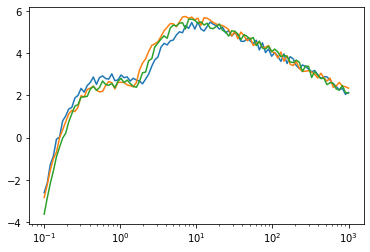

In [8]:
def normalize(X):
    X_n = np.log10(X)
    return X_n

X_n_train = normalize(X_train)
X_n_valid = normalize(X_valid)
X_n_test  = normalize(X_test)

plt.plot(wave_mu, X_n_train[0])
plt.plot(wave_mu, X_n_valid[0])
plt.plot(wave_mu, X_n_test[0])
plt.xscale('log')

## Autoncoder

<img src="images/autoencoder.png"/>

In [9]:
from keras import backend as K

def BuildSpectrum(x):
        
    wave_cm = wave_mu * 1e-4 # cm
    wave_cm = tf.expand_dims(wave_cm, axis=0)

    T_star = tf.gather(x, [0], axis=-1)
    N_star = tf.gather(x, [1], axis=-1)
    T_dust = tf.gather(x, [2], axis=-1)
    N_dust = tf.gather(x, [3], axis=-1)
#    Tau = tf.gather(x, [4], axis=-1)

    # Casting type float32->float64 to increase numerical accuracy:
    # (required to properly calculate the tails of the BB)
    T_star = tf.cast(T_star, tf.float64)
    N_star = tf.cast(N_star, tf.float64)
    T_dust = tf.cast(T_dust, tf.float64)
    N_dust = tf.cast(N_dust, tf.float64)
#    Tau = tf.cast(Tau, tf.float64)

    def BB(wave_cm, T, N):
        '''
        Returns a Black Body function evaluated over the <wave_cm> array, in:
            ergs/s/cm^2/Hz/sr

        Reproduces exactly the function defined as in:
            https://docs.astropy.org/en/stable/api/astropy.modeling.physical_models.BlackBody.html
        '''

        c = 3e10 # cm/sec
        freq_Hz = c / wave_cm
        h = 6.6261e-27 # cgs
        k = 1.3807e-16 # cgs

        ones = tf.cast(tf.ones(tf.size(wave_cm)), tf.float64)
        numerator   = 2*h*tf.pow(freq_Hz,3)/c**2
        denominator = tf.math.exp(h*freq_Hz/(k*T)) - ones

        eps= 1e-20
        # small additive constant to avoid numerical issues
        
        BB = N * numerator / denominator + eps
        #tf.print(BB)
        
        return BB
        
    BB_star = BB(wave_cm, T_star, N_star)
    BB_dust = BB(wave_cm, T_dust, N_dust)

    # Converting into flux density:
    sr = 1e-10
    # steradiants to convert ergs/s/cm^2/Hz/sr -> ergs/s/cm^2/Hz
    # (this is the same arbitrary value used when the spectra were generated)
    cgs_to_Jy = 1e-23
    # conversion factor for flux from ergs/s/cm^2/Hz -> Jansky

    BB_star = BB_star * sr / cgs_to_Jy
    BB_dust = BB_dust * sr / cgs_to_Jy

#    BB_star_abs = BB_star * tf.math.exp(-Tau/(wave_cm*1e4))
    # this must me in micron

#    BB = tf.add(BB_star_abs, BB_dust)
    BB = tf.add(BB_star, BB_dust)

    # Normalization:
    BB_log10 = tf.experimental.numpy.log10(BB)
    
    return BB_log10

In [19]:
from keras import backend as K

def CustomActivationFunction(x) :
    # https://stackoverflow.com/questions/44553722/restricting-the-output-values-of-layers-in-keras

    #tf.print('CustomAct: x', x[0,:])

    # Scaling around 1:
    # working best: x_renorm = K.sigmoid(x)*2 + 1
    # with: learning_rate=0.001, momentum=0.9, clipvalue=0.005
    #x_renorm = K.sigmoid(x)*2 + 1
    x_renorm = x
    #tf.print('CustomAct: x_renorm', x_renorm[0,:])

    # Grabbing layer's neuron values:
    T_star = tf.gather(x_renorm, [0], axis=-1)
    N_star = tf.gather(x_renorm, [1], axis=-1)
    T_dust = tf.gather(x_renorm, [2], axis=-1)
    N_dust = tf.gather(x_renorm, [3], axis=-1)
#    Tau    = tf.gather(x_renorm, [4], axis=-1)

    # Scaling -100% to 100% around average expected values:
    T_star = K.sigmoid(T_star)*3*6000
    N_star = K.sigmoid(N_star)*2*1e-6
    T_dust = K.sigmoid(T_dust)*2*500 + 50
    N_dust = K.sigmoid(N_dust)*2*1e0
#    Tau    = K.sigmoid(Tau)*1
    
#    x_activated = K.concatenate([T_star,N_star,T_dust,N_dust,Tau], axis=-1)
    x_activated = K.concatenate([T_star,N_star,T_dust,N_dust], axis=-1)

    #tf.print('CustomAct: x_act', x_activated[0,:])
    
    return x_activated

In [47]:
# Autoencoder: 
#     https://stackabuse.com/autoencoders-for-image-reconstruction-in-python-and-keras/
# Lambda layer:
#     https://keras.io/api/layers/core_layers/lambda/

# Batch normalization - theory:
#    https://datascience.stackexchange.com/questions/53426/what-exactly-is-batchnormalization-in-keras
# application:
#    https://stackoverflow.com/questions/34716454/where-do-i-call-the-batchnormalization-function-in-keras

from tensorflow.keras.layers import Dense, Input, InputLayer, Lambda, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import activations

n_inputs = X.shape[1]
n_latent = 4

def build_autoencoder(n_inputs, n_latent):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(n_inputs))
    #
    encoder.add(Dense(n_inputs))
    encoder.add(BatchNormalization())
    encoder.add(Activation('relu'))
    encoder.add(Dense(n_inputs/2))
    encoder.add(BatchNormalization())
    encoder.add(Activation('relu'))
    encoder.add(Dense(n_inputs/4))
    encoder.add(BatchNormalization())
    encoder.add(Activation('sigmoid'))
    encoder.add(Dense(n_latent, activation=CustomActivationFunction))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((n_latent,)))
    #
    decoder.add(Lambda(BuildSpectrum))

    decoder.layers[-1].trainable = False
    # not necessary, just here for redundancy
    
    return encoder, decoder

encoder, decoder = build_autoencoder(n_inputs, n_latent)

print(encoder.summary())
print(decoder.summary())
# Non-informative, in this case:
# print(model.summary())

#decoder.layers[-1].set_weights([[5000,1e-7,250,10],0])
#print('--', decoder.layers[-1].get_weights())

inp = Input(n_inputs)
encoded = encoder(inp)
reconstruction = decoder(encoded)

model = Model(inp, reconstruction)

# Compiling autoencoder model:
opt = SGD(learning_rate=0.01, momentum=0.9, clipvalue=0.5)
model.compile(optimizer=opt, run_eagerly=False, loss='mae')
# NOTE: run_eagerly=True allows to convert tensors to numpys
#       (useful for testing but less efficient)
#K.set_value(model.optimizer.learning_rate, 0.0001)
# default Keras learning rate = 0.001

weights_init = model.get_weights()
# saving initialization weights

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 100)               10100     
                                                                 
 batch_normalization_11 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 100)               0         
                                                                 
 dense_17 (Dense)            (None, 50)                5050      
                                                                 
 batch_normalization_12 (Bat  (None, 50)               200       
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 50)              

Epoch 1/100
13/13 - 2s - loss: 0.7025 - val_loss: 0.4257 - 2s/epoch - 136ms/step
Epoch 2/100
13/13 - 0s - loss: 0.3853 - val_loss: 0.2671 - 99ms/epoch - 8ms/step
Epoch 3/100
13/13 - 0s - loss: 0.2050 - val_loss: 0.2360 - 96ms/epoch - 7ms/step
Epoch 4/100
13/13 - 0s - loss: 0.1647 - val_loss: 0.2594 - 103ms/epoch - 8ms/step
Epoch 5/100
13/13 - 0s - loss: 0.1515 - val_loss: 0.2471 - 91ms/epoch - 7ms/step
Epoch 6/100
13/13 - 0s - loss: 0.1458 - val_loss: 0.2436 - 91ms/epoch - 7ms/step
Epoch 7/100
13/13 - 0s - loss: 0.1425 - val_loss: 0.2360 - 94ms/epoch - 7ms/step
Epoch 8/100
13/13 - 0s - loss: 0.1410 - val_loss: 0.2335 - 93ms/epoch - 7ms/step
Epoch 9/100
13/13 - 0s - loss: 0.1403 - val_loss: 0.2320 - 100ms/epoch - 8ms/step
Epoch 10/100
13/13 - 0s - loss: 0.1397 - val_loss: 0.2326 - 94ms/epoch - 7ms/step
Epoch 11/100
13/13 - 0s - loss: 0.1391 - val_loss: 0.2335 - 97ms/epoch - 7ms/step
Epoch 12/100
13/13 - 0s - loss: 0.1387 - val_loss: 0.2343 - 97ms/epoch - 7ms/step
Epoch 13/100
13/13 - 0s

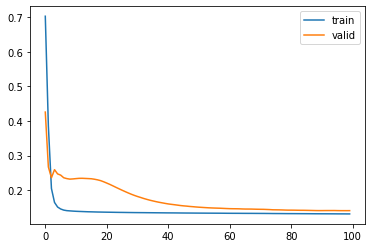

CPU times: user 31.4 s, sys: 2.01 s, total: 33.4 s
Wall time: 11.8 s


In [48]:
%%time
model.set_weights(weights_init)
# restoring initialized weights to have a fresh, identical fit very time model.fit() is run

# fit the autoencoder model to reconstruct input
history = model.fit(X_n_train, X_n_train, epochs=100, batch_size=512, verbose=2,
                    validation_data=(X_n_valid,X_n_valid), shuffle=False)
# plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

## Assessment

### Predicting

In [52]:
# Predict spectrum (full model):
X_n_test_pred = model.predict(X_n_test)
# Predict parameters (encoder only):
y_test_pred = encoder.predict(X_n_test)

### Comparing: prediction _vs_ true

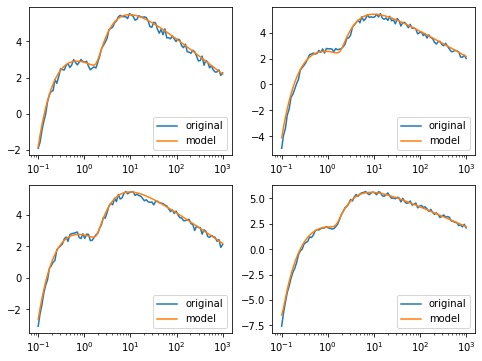

In [53]:
# Plotting a few test examples:
import random

fig, axes = plt.subplots(2,2, figsize=(8,6))
axes = axes.flatten()

for i, ax in enumerate(axes):

    j = random.randint(0, len(X_n_test))

    ax.plot(wave_mu, X_n_test[j], label='original')
    ax.plot(wave_mu, X_n_test_pred[j], label='model')
    ax.set_xscale('log')
    ax.legend()

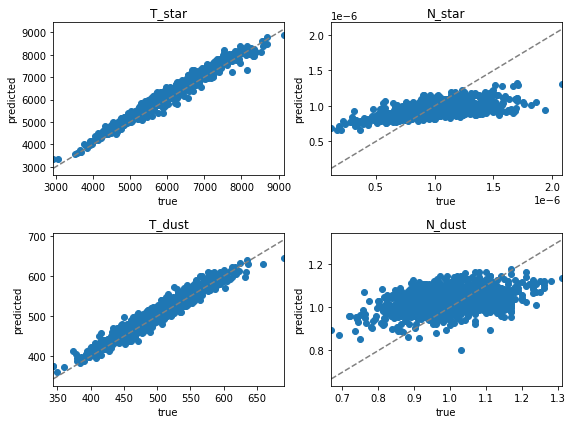

In [54]:
y_test = np.array([np.fromiter(params.values(), dtype=float) for params in Y_test])
# converting dictionary to np.array

y_params = list(Y_test[0].keys())
# parameter names: the same for all spectra (using the first)

fig, axes = plt.subplots(2,2, figsize=(8,6))
axes = axes.flatten()

for i, ax in enumerate(axes):
# i = parameter index

    if i+1 > len(y_params):
    # to delete extra panels in case we plot more than 4 parameters
        fig.delaxes(ax)

    min_ax, max_ax = np.min(y_test[:,i]), np.max(y_test[:,i])
    # 1-to-1 line:
    xx = np.linspace(min_ax, max_ax, 100)
    ax.plot(xx, xx, c="grey", linestyle='--')

    ax.scatter(y_test[:,i], y_test_pred[:,i])
    ax.set_title(y_params[i])
    ax.set_xlabel('true')
    ax.set_ylabel('predicted')
    ax.set_xlim([min_ax, max_ax])
    #ax.set_ylim([min_ax, max_ax])

    #ax.set_aspect('equal', 'box')

fig.tight_layout()
plt.show()

In [ ]:
###EOF